# Cleaning TESS Data with Fourier analysis

In this notebook, I will show a method to clean and normalize TESS light curves, using Fourier analysis

Vicente Maldonado - April 2022

In [ ]:
!pip install lightkurve

In [ ]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u

We start downloading the TESS data. We can use individual files or stitch some of them. In this case, we choose a lightcurve with $120 s$ of exp time of the planet HATS-34.

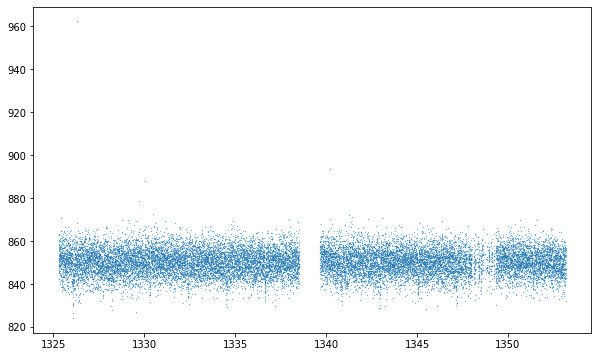

In [ ]:
search_result = lk.search_lightcurve('HATS-34', mission='TESS')[0]
lc_raw = search_result.download()

lc = pd.DataFrame()
lc['# time'] = lc_raw['time'].value.astype(float)
lc['flux'] = lc_raw['flux'].value.astype(float)

# visualize
plt.figure(figsize=(10,6))
plt.plot(lc['# time'], lc['flux'], '.', ms=0.5)
plt.show()

We can note a baseline of $≈ 850$ and some outliers. Now we delete points out of $0.05$ the root mean squared (in the next cells we will use rms as baseline)

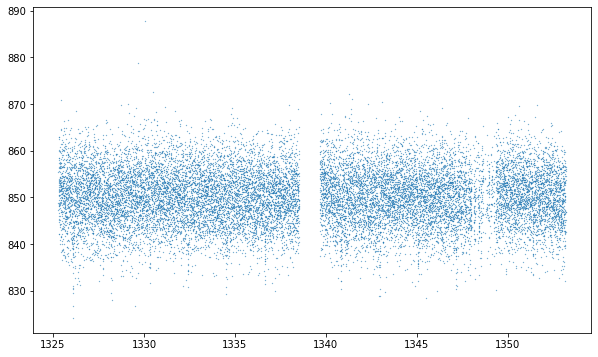

In [ ]:
rms = np.sqrt(np.mean(lc['flux']**2))
lc = lc[abs(lc['flux']-rms)<=0.05*rms]

plt.figure(figsize=(10,6))
plt.plot(lc['# time'], lc['flux'], '.', ms=0.5)
plt.show()

The next step is transform the flux to Fourier space, and time to freuencies.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


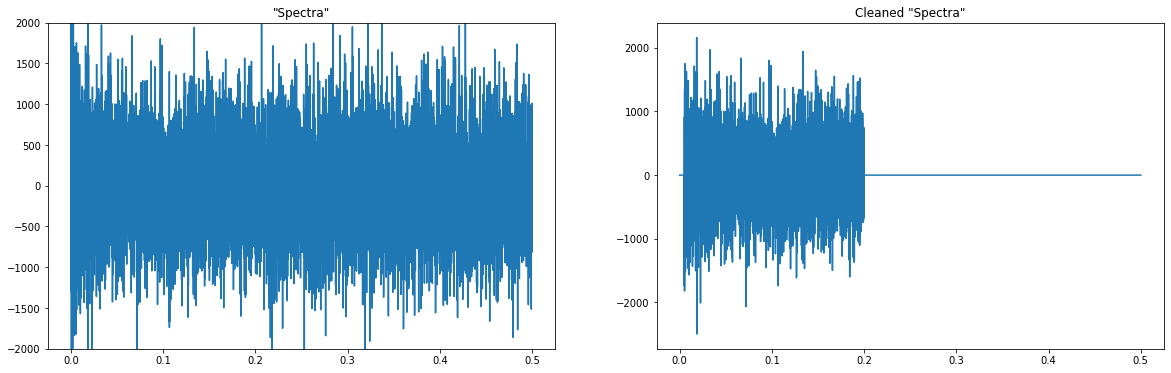

In [ ]:
f_min = 0.005
f_max = 0.2

# fourier transform
fourier_flux = np.fft.rfft(lc['flux'])
fourier_time = np.fft.rfftfreq(len(lc['# time']))

# plot spectra
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(hspace=0.3)

ax = axes[0]
ax.plot(fourier_time, fourier_flux)
ax.set_title('"Spectra"')
ax.set_ylim(-2000,2000)

# we set 0 small and big frequencies, be careful of not deleting the period !! 
for i in range(len(fourier_time)):
    if fourier_time[i]<f_min:
        fourier_flux[i] = 0
    if fourier_time[i]>f_max:
        fourier_flux[i] = 0

# plot corrected spectra
ax = axes[1]
ax.plot(fourier_time, fourier_flux)
ax.set_title('Cleaned "Spectra"')

fig.show()

We save the corrected lightcurve and run "flatten" from lightkurve, then compare the results

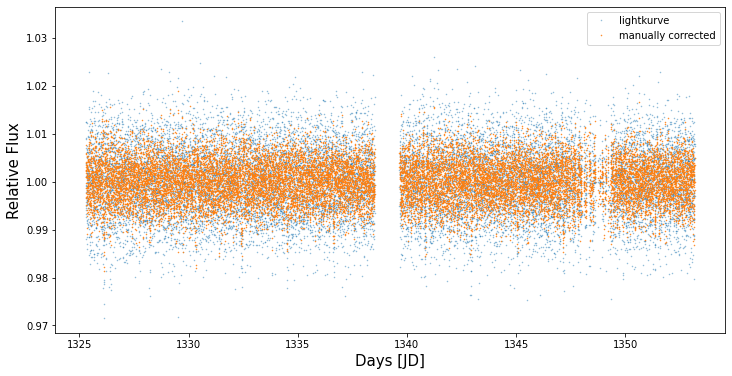

In [ ]:
# we make the inverse transform
lc_flux_corr = np.fft.irfft(fourier_flux)

# save it
lc_corr = pd.DataFrame()
lc_corr['time'] = lc['# time'][1:]
lc_corr['flux'] = lc_flux_corr/rms +1 # normalized

# correct with lightkurve
lc_retocada = lc_raw.flatten(351).remove_outliers()

plt.figure(figsize=(12,6))
plt.plot(lc_retocada.time.value, lc_retocada.flux.value, '.', ms=1, label='lightkurve', alpha =0.5)
plt.plot(lc_corr['time'], lc_corr['flux'], '.', ms=1, label='manually corrected')
plt.xlabel('Days [JD]', size=15)
plt.ylabel('Relative Flux', size=15)
plt.legend()
plt.show()

Let's look at the phase diagram

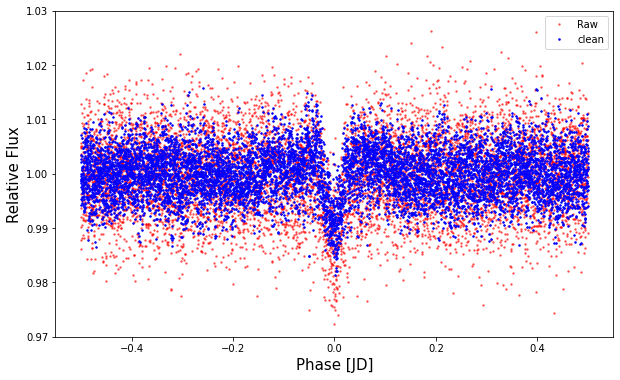

In [ ]:
# we set a period and a t_0 (we can search it with BoxLeastSquared from astropy) 
t0 = 1326.1074949636711
period = 2.1062106210621065

# phase diagram
plt.figure(figsize=(10,6))

x = (lc_corr['time'] - t0 + 0.5*period) % period - 0.5*period
x_raw = (lc_raw['time'].value.astype(float) - t0 + 0.5*period) % period - 0.5*period

m = np.abs(x) < 0.5 * u.day
m_raw = np.abs(x_raw) < 0.5 

plt.plot(x_raw[m_raw], lc_raw['flux'].value.astype(float)[m_raw]/rms, 'r.', ms=3, label='Raw' ,alpha=0.5)

plt.plot(x[m], lc_corr['flux'][m], "b.", label='clean', ms=3)

plt.xlabel('Phase [JD]', size=15)
plt.ylabel('Relative Flux', size=15)
plt.ylim([0.97, 1.03])
plt.legend()
plt.show()

In [ ]:
print('number of points:')
print('original:',len(lc_raw))
print('corrected', len(lc_corr))

number of points:
original: 18279
corrected 18274


pro hacer

*   Hacerlo con varias lc al mismo tiempo
*   Hacerlo con error
*   Automatizar los limites de frecuencia
*   Realizar un test de residuos
*   Hacerlo con un transito observado





